In [ ]:
import glob, scipy, json, re, time, pickle
import pandas as pd
import workers
from multiprocessing import Pool
import numpy as np
import matplotlib.pyplot as plt
import feather, pytz, spacy, datetime
from itertools import chain
from datetime import timezone
import en_core_web_sm
nlp = en_core_web_sm.load()

from sentence_transformers import SentenceTransformer
sbert = SentenceTransformer('bert-base-nli-mean-tokens')

# Preprocess replies

In [2]:
def extract_tweet_info(x):
    return [x['id'], int(x['created_at']/1000), x.get('user_id', ''), x['tweet']]

file_list = glob.glob('./dat/covid_antibiotics_replies/*.json')

sampled_tweets = []
for file in file_list:
    for line in open(file, 'r', encoding='utf-8'):
        sampled_tweets.append(extract_tweet_info(json.loads(line)))
        
sampled_tweets_df = pd.DataFrame(sampled_tweets, columns=['id', 'created', 'uid', 'text'])
print(sampled_tweets_df.shape)

(16396, 4)


In [3]:
covid_df = sampled_tweets_df.copy()
covid_df.index = covid_df.created.apply(lambda x: datetime.datetime.fromtimestamp(x, pytz.utc))
covid_df = covid_df.sort_index()

criteria  = (covid_df.index.year==2020)
covid_df = covid_df[criteria]
print("size of df in the year 2020:", covid_df.shape)

covid_df = covid_df.drop_duplicates()
print("size of df after dropping duplicates:", covid_df.shape)

size of df in the year 2020: (16383, 4)
size of df after dropping duplicates: (16383, 4)


(array([737425., 737439., 737456., 737470., 737485., 737499., 737516.]),
 <a list of 7 Text xticklabel objects>)

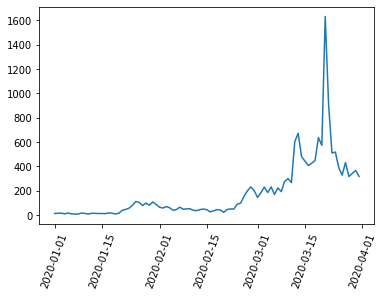

In [4]:
covid_df = covid_df[covid_df.index.date<=datetime.date(2020,3,31)]
pd.plotting.register_matplotlib_converters()

plt.plot(covid_df.groupby(lambda x: x.date)['text'].count())
plt.xticks(rotation=70)

## Clean text

In [5]:
num_processors = 10
p=Pool(processes = num_processors)
%time output = p.map(workers.twitter_preprocessing, covid_df.text)
p.close()
p.terminate()

Wall time: 185 ms


In [ ]:
sbert_embs = np.array(sbert.encode(output, show_progress_bar=True, batch_size=20))

In [ ]:
# fname = './covid_tweet_replies_embs_mar31_utc_timezone.npy'
# np.save(fname, np.array(sbert_embs))